# Machine Learning Models

This part will consist of two ML Models.
Regression and Classification.

## Building the ML Table (movies + Aggregated review signals)

In [49]:
# Just the imports
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)


In [50]:
# Loading cleaned datasets
movies = pd.read_csv("../data_clean/movies_clean.csv")
reviews = pd.read_csv("../data_clean/reviews_tmdb_clean.csv")

print("movies shape:", movies.shape)
print("reviews shape:", reviews.shape)

display(movies.head())
display(reviews.head())


movies shape: (836, 8)
reviews shape: (2099, 7)


,title,year,runtime_min,genre,imdb_rating,director,votes,Gross
0,Alien,1979,117,"Horror, Sci-Fi",8.5,Ridley Scott,905275,$78.90M
1,Psycho,1960,109,"Horror, Mystery, Thriller",8.5,Alfred Hitchcock,689068,$32.00M
2,The Shining,1980,146,"Drama, Horror",8.4,Stanley Kubrick,1051582,$44.02M
3,The Thing,1982,109,"Horror, Mystery, Sci-Fi",8.2,John Carpenter,439793,$13.78M
4,Tumbbad,2018,104,"Drama, Fantasy, Horror",8.2,Rahi Anil Barve,53297,NaN


,tmdb_id,author,review_text,created_at,rating,title,year
0,348,Patrick E. Abe,"Described by Roger Ebert as a ""trapped in a ha...",2016-09-21T08:25:53.208Z,8.0,Alien,1979
1,348,John Chard,There is a clause in the contract which specif...,2019-05-12T22:00:41.553Z,10.0,Alien,1979
2,348,Repo Jack,"The standard bearer of horror in space, Ridley...",2020-10-28T03:47:15.868Z,10.0,Alien,1979
3,348,r96sk,"<em>'Alien'</em> isn't as eventful, and as suc...",2022-02-21T20:06:15.195Z,8.0,Alien,1979
4,348,GenerationofSwine,"Horror in Space, that's what this is. It's a s...",2023-01-13T23:03:48.663Z,10.0,Alien,1979


In [52]:
#Ensuring merge keys (title + year) are cleaaaan
def normalize_title(x):
    if pd.isna(x):
        return ""
    return str(x).strip().lower()

# movies side
movies["title_norm"] = movies["title"].apply(normalize_title) #all title names are now lower case, no leading/trailing spaces
movies["year"] = pd.to_numeric(movies["year"], errors="coerce")

# reviews side (based on your screenshot)
reviews["title_norm"] = reviews["title"].apply(normalize_title)
reviews["year_norm"] = pd.to_numeric(reviews["year"], errors="coerce")

print(movies[["title","title_norm","year"]].head())
print(reviews[["title","title_norm","year"]].head())


         title   title_norm  year
0        Alien        alien  1979
1       Psycho       psycho  1960
2  The Shining  the shining  1980
3    The Thing    the thing  1982
4      Tumbbad      tumbbad  2018
   title title_norm  year
0  Alien      alien  1979
1  Alien      alien  1979
2  Alien      alien  1979
3  Alien      alien  1979
4  Alien      alien  1979


In [53]:
# A Loooong list of fear-related keywords
fear_words = [
    # death / killing
    "death","dead","die","dies","dying",
    "kill","kills","killed","killing","murder","murderer","homicide",
    "slay","slaughter","massacre","execute","execution",

    # blood / gore / body horror
    "blood","bloody","gore","gory","gruesome","brutal","brutality",
    "dismember","dismembered","dismemberment",
    "decapitate","decapitated","decapitation",
    "mutilate","mutilated","mutilation",
    "torture","tortured","torturing",
    "corpse","cadaver","autopsy",
    "wound","wounds","injury","injuries",
    "stab","stabbed","stabbing",
    "slash","slashed","slashing",

    # fear / panic / anxiety
    "fear","scared","scary","terrified","terror","panic","panicked",
    "dread","dreading","horrified","horror",
    "anxiety","anxious","uneasy","disturb","disturbing","unsettling",
    "creepy","eerie","spooky","sinister",

    # darkness / isolation / helplessness
    "dark","darkness","shadow","shadows",
    "alone","lonely","isolation","isolated","trapped","helpless",
    "claustrophobic","claustrophobia",

    # supernatural / paranormal
    "ghost","ghosts","haunt","haunted","haunting",
    "spirit","spirits","poltergeist",
    "demon","demons","devil","satan","hell",
    "curse","cursed","possession","possessed","exorcism",
    "witch","witches","occult","ritual","rituals",
    "paranormal","supernatural",

    # monsters / creatures
    "monster","monsters","creature","creatures","beast","beasts",
    "vampire","vampires","werewolf","werewolves",
    "zombie","zombies","undead",
    "alien","aliens",

    # suspense / common themes
    "nightmare","nightmares",
    "jump scare","jumpscare",
    "suspense","tension","tense",
    "serial killer","psychopath","cannibal","cannibalism"
]


In [54]:
# Fear keyword matching in reviews. Calculating four things.
text_col = "review_text" 

phrase_keywords = [w for w in fear_words if " " in w]
single_keywords = [w for w in fear_words if " " not in w]

phrase_patterns = [re.compile(re.escape(p)) for p in phrase_keywords]
single_patterns = [re.compile(r"\b" + re.escape(w) + r"\b") for w in single_keywords]

def fear_count(text):
    if not isinstance(text, str):
        return 0
    t = re.sub(r"\s+", " ", text.lower())
    cnt = 0
    for pat in phrase_patterns:
        cnt += len(pat.findall(t))
    for pat in single_patterns:
        cnt += len(pat.findall(t))
    return cnt

def fear_density(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0.0
    words = re.findall(r"\b\w+\b", text.lower())
    if len(words) == 0:
        return 0.0
    return fear_count(text) / len(words)

reviews[text_col] = reviews[text_col].fillna("").astype(str)
reviews["review_len"] = reviews[text_col].str.len()

reviews["fear_count"] = reviews[text_col].apply(fear_count) # how many fear-keyword matches in that review
reviews["fear_density"] = reviews[text_col].apply(fear_density) #fear_count divided by the number of words (so long reviews don’t automatically look “more scary”)
reviews["has_fear"] = (reviews["fear_count"] > 0).astype(int)

reviews[["fear_count","fear_density","has_fear","review_len"]].describe()


,fear_count,fear_density,has_fear,review_len
count,2099.000000,2099.000000,2099.000000,2099.000000
mean,4.089566,0.018258,0.781801,1365.145784
std,5.357530,0.020271,0.413122,1547.652016
min,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.004376,1.000000,444.000000
50%,2.000000,0.014184,1.000000,982.000000
75%,5.000000,0.025388,1.000000,1692.500000
max,52.000000,0.333333,1.000000,20645.000000


In [55]:
reviews.sort_values("fear_count", ascending=False)[[text_col, "fear_count"]].head(5)

,review_text,fear_count
1579,"_**Not a patch on the book, and the new ending...",52
1019,We certainly get the inside joke about wanting...,50
2037,There are certain film franchises that just ca...,43
1813,In filmmaker Scott Derrickson’s original ‘Sini...,43
1946,When _The Blair Witch Project_ burst upon the ...,42


In [56]:
# Finding the seniment labels of the ratings. 
rating_col = "rating"  

reviews[rating_col] = pd.to_numeric(reviews[rating_col], errors="coerce")

def sentiment_from_rating(x):
    if pd.isna(x):
        return np.nan
    if x >= 7:
        return "pos"
    elif x >= 5:
        return "neu"
    else:
        return "neg"

reviews["sentiment"] = reviews[rating_col].apply(sentiment_from_rating)
reviews["sentiment"].value_counts(dropna=False)


sentiment
pos    1009
neu     624
neg     335
NaN     131
Name: count, dtype: int64

In [57]:
agg = (reviews
       .groupby(["title_norm", "year_norm"])
       .agg(
           review_count=(text_col, "count"),
           avg_review_rating=(rating_col, "mean"),
           avg_review_len=("review_len", "mean"),

           fear_review_ratio=("has_fear", "mean"),
           avg_fear_count=("fear_count", "mean"),
           avg_fear_density=("fear_density", "mean"),

           pos_ratio=("sentiment", lambda x: (x=="pos").mean()),
           neu_ratio=("sentiment", lambda x: (x=="neu").mean()),
           neg_ratio=("sentiment", lambda x: (x=="neg").mean()),
       )
       .reset_index()
)

display(agg.head())
print("Aggregated movies from reviews:", len(agg))


,title_norm,year_norm,review_count,avg_review_rating,avg_review_len,fear_review_ratio,avg_fear_count,avg_fear_density,pos_ratio,neu_ratio,neg_ratio
0,#alive,2020,2,8.500000,1261.000000,1.000000,9.500000,0.037732,1.000000,0.000000,0.0
1,10 cloverfield lane,2016,5,7.600000,1493.600000,0.800000,3.600000,0.013449,0.800000,0.200000,0.0
2,13 sins,2014,1,5.000000,1451.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
3,1408,2007,4,7.000000,683.000000,0.500000,3.250000,0.017618,0.500000,0.500000,0.0
4,1922,2017,3,6.666667,905.333333,0.666667,1.333333,0.009166,0.333333,0.666667,0.0


Aggregated movies from reviews: 664


In [58]:
df = movies.merge(
    agg,
    left_on=["title_norm", "year"],
    right_on=["title_norm", "year_norm"],
    how="left"
)

# fill movies with no reviews
for c in ["review_count","avg_review_rating","avg_review_len",
          "fear_review_ratio","avg_fear_count","avg_fear_density",
          "pos_ratio","neu_ratio","neg_ratio"]:
    df[c] = df[c].fillna(0)

# numeric transforms
df["votes"] = pd.to_numeric(df["votes"], errors="coerce").fillna(0)
df["runtime"] = pd.to_numeric(df["runtime"], errors="coerce") if "runtime" in df.columns else df.get("runtime", 0)
df["log_votes"] = np.log1p(df["votes"])

print("Final ML table shape:", df.shape)
print("Movies with >=1 review:", (df["review_count"] > 0).sum())
display(df.head())
df.to_csv("../data_clean/ml_table.csv", index=False)
print("Saved: ../data_clean/ml_table.csv")



Final ML table shape: (836, 21)
Movies with >=1 review: 664


,title,year,runtime_min,genre,imdb_rating,director,votes,Gross,title_norm,year_norm,...,avg_review_rating,avg_review_len,fear_review_ratio,avg_fear_count,avg_fear_density,pos_ratio,neu_ratio,neg_ratio,runtime,log_votes
0,Alien,1979,117,"Horror, Sci-Fi",8.5,Ridley Scott,905275,$78.90M,alien,1979.0,...,8.900000,971.400000,0.700000,4.800000,0.029282,1.000000,0.000000,0.0,0,13.715995
1,Psycho,1960,109,"Horror, Mystery, Thriller",8.5,Alfred Hitchcock,689068,$32.00M,psycho,1960.0,...,8.600000,757.166667,0.500000,1.333333,0.012110,0.833333,0.000000,0.0,0,13.443097
2,The Shining,1980,146,"Drama, Horror",8.4,Stanley Kubrick,1051582,$44.02M,the shining,1980.0,...,8.714286,1670.142857,0.857143,4.142857,0.015360,1.000000,0.000000,0.0,0,13.865807
3,The Thing,1982,109,"Horror, Mystery, Sci-Fi",8.2,John Carpenter,439793,$13.78M,the thing,1982.0,...,8.444444,1935.000000,0.888889,10.222222,0.029640,0.888889,0.111111,0.0,0,12.994062
4,Tumbbad,2018,104,"Drama, Fantasy, Horror",8.2,Rahi Anil Barve,53297,NaN,tumbbad,2018.0,...,8.000000,549.000000,1.000000,1.333333,0.025184,1.000000,0.000000,0.0,0,10.883654


Saved: ../data_clean/ml_table.csv


## Classification: Scary vs Not Scary

In [59]:
# Creating the Scary Label
df_cls = df.copy()
df_cls["scary"] = (df_cls["fear_review_ratio"] >= df_cls["fear_review_ratio"].median()).astype(int)

print(df_cls["scary"].value_counts())

scary
0    418
1    418
Name: count, dtype: int64


In [60]:
# Preparing features for metadata and prepocessing
X_cols_num = [c for c in ["year", "runtime", "log_votes"] if c in df_cls.columns]
X_cols_cat = [c for c in ["genre"] if c in df_cls.columns]

X_cols = X_cols_num + X_cols_cat
print("Classification features:", X_cols)

# Preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), X_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), X_cols_cat),
    ],
    remainder="drop"
)

X = df_cls[X_cols].copy()
y = df_cls["scary"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Classification features: ['year', 'runtime', 'log_votes', 'genre']


In [61]:
# Training two classification models. 
models_cls = {
    "BaselineMajority": DummyClassifier(strategy="most_frequent"),
    "LogisticRegression": LogisticRegression(max_iter=3000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
}

results = []

for name, model in models_cls.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    results.append({"model": name, "accuracy": acc, "f1": f1})

# And evaluation results. (How accurate are the models?)
cls_results = pd.DataFrame(results).sort_values("f1", ascending=False)
display(cls_results)


,model,accuracy,f1
2,RandomForest,0.553571,0.550898
1,LogisticRegression,0.529762,0.496815
0,BaselineMajority,0.500000,0.000000


In [62]:
# The detailed Results:
best_model_name = cls_results.iloc[0]["model"]   # assuming cls_results is sorted by f1 desc
print("Best model:", best_model_name)

best_model = models_cls[best_model_name]         # your dict
best_pipe = Pipeline([("prep", preprocess), ("model", best_model)])

best_pipe.fit(X_train, y_train)
pred = best_pipe.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification Report:\n")
print(classification_report(y_test, pred))


Best model: RandomForest
Confusion Matrix:
 [[47 37]
 [38 46]]

Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.56      0.56        84
           1       0.55      0.55      0.55        84

    accuracy                           0.55       168
   macro avg       0.55      0.55      0.55       168
weighted avg       0.55      0.55      0.55       168



In [ ]:
# Creating predictions table --> can found it in ml_table.csv
# Making sure we have titles for interpretation
cls_pred_df = df_cls.loc[X_test.index, ["title", "year"]].copy()
cls_pred_df["y_true"] = y_test.values
cls_pred_df["y_pred"] = pred

# If the model supports probabilities, store them
if hasattr(best_pipe.named_steps["model"], "predict_proba"):
    cls_pred_df["p_scary"] = best_pipe.predict_proba(X_test)[:, 1]

display(cls_pred_df.head(10))

cls_pred_df.to_csv("../predictions_classification.csv", index=False)
print("Saved: ../predictions_classification.csv")


,title,year,y_true,y_pred,p_scary
2,The Shining,1980,1,1,0.533333
644,Club Dread,2004,1,0,0.453333
331,Escape Room I,2019,1,0,0.226667
488,House,1985,0,1,0.653333
782,The Woman in Black 2: Angel of Death,2014,0,0,0.426667
474,Crawl I,2019,1,1,0.610000
214,Dead Snow 2: Red vs. Dead,2014,1,0,0.416667
373,Scream 2,1997,1,1,0.850000
322,Byzantium,2012,1,1,0.570000
143,Orphan,2009,0,1,0.540000


Saved: ../predictions_classification.csv


In [64]:
# To show the biggest misclassifications
mis = cls_pred_df[cls_pred_df["y_true"] != cls_pred_df["y_pred"]].copy()
print("Misclassified count:", len(mis))
display(mis.head(15))


Misclassified count: 75


,title,year,y_true,y_pred,p_scary
644,Club Dread,2004,1,0,0.453333
331,Escape Room I,2019,1,0,0.226667
488,House,1985,0,1,0.653333
214,Dead Snow 2: Red vs. Dead,2014,1,0,0.416667
143,Orphan,2009,0,1,0.540000
127,Don't Look Now,1973,0,1,0.783333
372,Watcher I,2022,0,1,0.600000
64,The Wailing,2016,1,0,0.216667
627,Friday the 13th Part III,1982,0,1,0.663333
535,King Kong,1976,0,1,0.630000


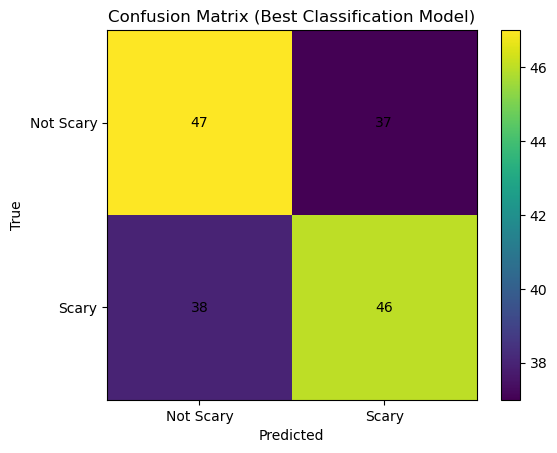

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Best Classification Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["Not Scary","Scary"])
plt.yticks([0,1], ["Not Scary","Scary"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.colorbar()
plt.show()


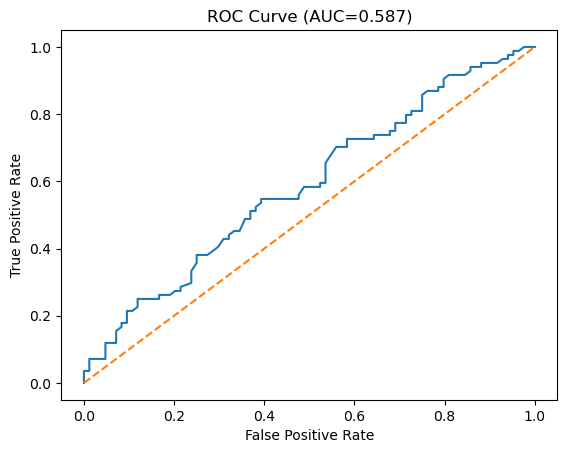

In [69]:
from sklearn.metrics import roc_curve, auc

if "p_scary" in cls_pred_df.columns:
    fpr, tpr, _ = roc_curve(cls_pred_df["y_true"], cls_pred_df["p_scary"])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.title(f"ROC Curve (AUC={roc_auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


## Regression: Predicting IMDb Rating

In [72]:
print("DF columns:", list(df.columns))


DF columns: ['title', 'year', 'runtime_min', 'genre', 'imdb_rating', 'director', 'votes', 'Gross', 'title_norm', 'year_norm', 'review_count', 'avg_review_rating', 'avg_review_len', 'fear_review_ratio', 'avg_fear_count', 'avg_fear_density', 'pos_ratio', 'neu_ratio', 'neg_ratio', 'runtime', 'log_votes']


In [77]:
# Regression feature sets + preprocessing
df_reg = df[df["imdb_rating"].notna()].copy()
target_reg = "imdb_rating"

base_num = [c for c in ["year", "runtime", "log_votes"] if c in df_reg.columns]
base_cat = [c for c in ["genre"] if c in df_reg.columns]

review_feats = [c for c in [
    "review_count","avg_review_rating","avg_review_len",
    "fear_review_ratio","avg_fear_count","avg_fear_density",
    "pos_ratio","neu_ratio","neg_ratio"
] if c in df_reg.columns]

FEATURE_SETS = {
    "BASE": base_num + base_cat,
    "FULL": base_num + base_cat + review_feats
}

def make_preprocess(num_cols, cat_cols):
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop"
    )

print("BASE:", FEATURE_SETS["BASE"])
print("FULL:", FEATURE_SETS["FULL"])


BASE: ['year', 'runtime', 'log_votes', 'genre']
FULL: ['year', 'runtime', 'log_votes', 'genre', 'review_count', 'avg_review_rating', 'avg_review_len', 'fear_review_ratio', 'avg_fear_count', 'avg_fear_density', 'pos_ratio', 'neu_ratio', 'neg_ratio']


In [78]:
# Again training two models. 
models_reg = {
    "BaselineMean": DummyRegressor(strategy="mean"),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
}

def eval_reg(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # no squared=False
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

reg_results = []

for set_name, cols in FEATURE_SETS.items():
    num_cols = [c for c in cols if c in (base_num + review_feats)]
    cat_cols = [c for c in cols if c in base_cat]
    preprocess = make_preprocess(num_cols, cat_cols)

    X = df_reg[cols].copy()
    y = df_reg["imdb_rating"].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for model_name, model in models_reg.items():
        pipe = Pipeline([("prep", preprocess), ("model", model)])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        mae, rmse, r2 = eval_reg(y_test, pred)
        reg_results.append({
            "feature_set": set_name,
            "model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

reg_results_df = pd.DataFrame(reg_results).sort_values(["feature_set","RMSE"])
display(reg_results_df)


,feature_set,model,MAE,RMSE,R2
1,BASE,Ridge,0.605733,0.791084,0.341303
2,BASE,RandomForest,0.606885,0.804203,0.319275
0,BASE,BaselineMean,0.754603,0.976239,-0.003120
5,FULL,RandomForest,0.512282,0.687955,0.501849
4,FULL,Ridge,0.551612,0.736657,0.428823
3,FULL,BaselineMean,0.754603,0.976239,-0.003120


In [79]:
best_cols = FEATURE_SETS["FULL"]
num_cols = [c for c in best_cols if c in (base_num + review_feats)]
cat_cols = [c for c in best_cols if c in base_cat]
preprocess_full = make_preprocess(num_cols, cat_cols)

X = df_reg[best_cols].copy()
y = df_reg[target_reg].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_reg_pipe = Pipeline([
    ("prep", preprocess_full),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

best_reg_pipe.fit(X_train, y_train)
y_pred = best_reg_pipe.predict(X_test)


In [80]:
reg_pred_df = df_reg.loc[X_test.index, ["title", "year"]].copy()
reg_pred_df["y_true"] = y_test.values
reg_pred_df["y_pred"] = y_pred
reg_pred_df["abs_error"] = (reg_pred_df["y_true"] - reg_pred_df["y_pred"]).abs()

display(reg_pred_df.head(10))
display(reg_pred_df.sort_values("abs_error", ascending=False).head(15))

reg_pred_df.to_csv("../predictions_regression.csv", index=False)
print("Saved: ../predictions_regression.csv")


,title,year,y_true,y_pred,abs_error
611,Honeymoon,2014,5.7,5.931333,0.231333
823,The Fog,2005,3.7,4.417667,0.717667
290,Gerald's Game,2017,6.5,6.475667,0.024333
801,Rings,2017,4.5,5.614333,1.114333
168,Climax I,2018,6.9,6.146667,0.753333
689,Jessabelle,2014,5.4,5.019333,0.380667
822,Jaws 3-D,1983,3.7,4.696000,0.996000
86,Take Shelter,2011,7.3,6.121000,1.179000
260,The Faculty,1998,6.6,6.068000,0.532000
548,P2,2007,5.9,5.768000,0.132000


,title,year,y_true,y_pred,abs_error
831,Troll 2,1990,2.9,5.896000,2.996000
832,Laxmii,2020,2.5,5.425000,2.925000
10,The Blue Elephant,2014,8.0,5.703333,2.296667
39,One Cut of the Dead,2017,7.6,6.086667,1.513333
816,Halloween: Resurrection,2002,3.9,5.371000,1.471000
139,Thirst,2009,7.1,5.700667,1.399333
794,Psycho,1998,4.6,5.965000,1.365000
778,Leprechaun,1993,4.8,6.158333,1.358333
86,Take Shelter,2011,7.3,6.121000,1.179000
110,Ringu,1998,7.2,6.064333,1.135667


Saved: ../predictions_regression.csv


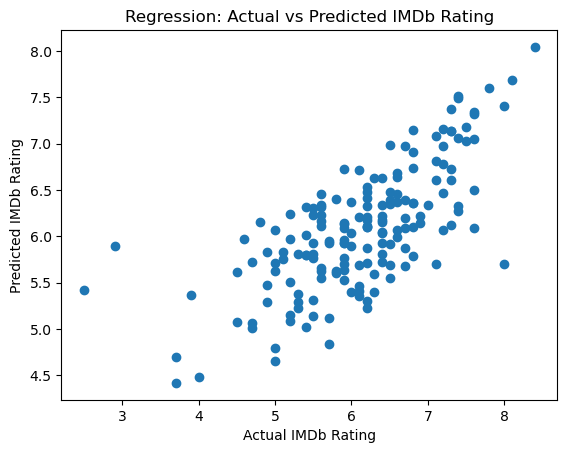

In [81]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(reg_pred_df["y_true"], reg_pred_df["y_pred"])
plt.title("Regression: Actual vs Predicted IMDb Rating")
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.show()


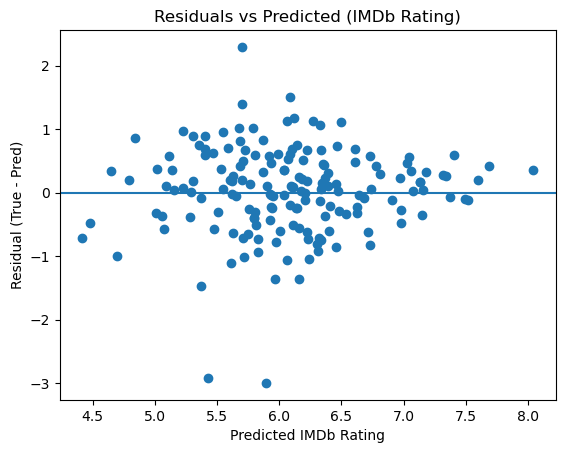

In [82]:
residuals = reg_pred_df["y_true"] - reg_pred_df["y_pred"]

plt.figure()
plt.scatter(reg_pred_df["y_pred"], residuals)
plt.title("Residuals vs Predicted (IMDb Rating)")
plt.xlabel("Predicted IMDb Rating")
plt.ylabel("Residual (True - Pred)")
plt.axhline(0)
plt.show()


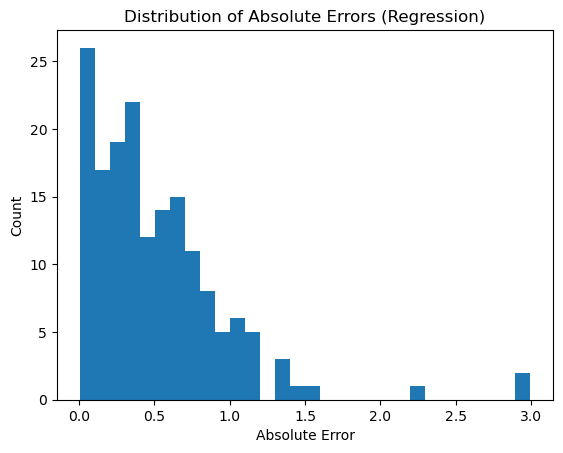

In [83]:
plt.figure()
plt.hist(reg_pred_df["abs_error"], bins=30)
plt.title("Distribution of Absolute Errors (Regression)")
plt.xlabel("Absolute Error")
plt.ylabel("Count")
plt.show()
